# Importing packages

In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import radius_graph
import enum
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_scatter import scatter_add
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os

## Helper Functions

In [2]:
def decompose_graph(graph):
    # graph: torch_geometric.data.data.Data
    # TODO: make it more robust
    x, edge_index, edge_attr, global_attr = None, None, None, None
    for key in graph.keys():
        if key=="x":
            x = graph.x
        elif key=="edge_index":
            edge_index = graph.edge_index
        elif key=="edge_attr":
            edge_attr = graph.edge_attr
        elif key=="global_attr":
            global_attr = graph.global_attr
        else:
            pass
    return (x, edge_index, edge_attr, global_attr)

def copy_geometric_data(graph):
    """return a copy of torch_geometric.data.data.Data
    This function should be carefully used based on
    which keys in a given graph.
    """
    node_attr, edge_index, edge_attr, global_attr = decompose_graph(graph)

    ret = Data(x=node_attr, edge_index=edge_index, edge_attr=edge_attr)
    ret.global_attr = global_attr

    return ret

In [3]:
def build_mlp(in_size, hidden_size, out_size, lay_norm=True):

    module = nn.Sequential(nn.Linear(in_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, out_size))
    if lay_norm: return nn.Sequential(module,  nn.LayerNorm(normalized_shape=out_size))
    return module

# Blocks

In [4]:
class EdgeBlock(nn.Module):
    """ EdgeBlock, a block that updates edge attributes

    Args:
        custom_func: nn.Module, a custom function that updates edge attributes
    """

    def __init__(self, custom_func=None):
        super(EdgeBlock, self).__init__()
        self.net = custom_func

    def forward(self, graph):
        node_attr, edge_index, edge_attr, _ = decompose_graph(graph)
        senders_idx, receivers_idx = edge_index
        edges_to_collect = []

        senders_attr = node_attr[senders_idx]
        receivers_attr = node_attr[receivers_idx]

        edges_to_collect.append(senders_attr)
        edges_to_collect.append(receivers_attr)
        edges_to_collect.append(edge_attr)

        collected_edges = torch.cat(edges_to_collect, dim=1)

        edge_attr_ = self.net(collected_edges)   # Update

        return Data(x=node_attr, edge_attr=edge_attr_, edge_index=edge_index)

class NodeBlock(nn.Module):
    """ NodeBlock, a block that updates node attributes

    Args:
        custom_func: nn.Module, a custom function that updates node attributes
    """

    def __init__(self, custom_func=None):
        super(NodeBlock, self).__init__()
        self.net = custom_func

    def forward(self, graph):
        # Decompose graph
        edge_attr = graph.edge_attr
        nodes_to_collect = []

        _, receivers_idx = graph.edge_index
        num_nodes = graph.num_nodes
        agg_received_edges = scatter_add(edge_attr, receivers_idx, dim=0, dim_size=num_nodes)

        nodes_to_collect.append(graph.x)
        nodes_to_collect.append(agg_received_edges)
        collected_nodes = torch.cat(nodes_to_collect, dim=-1)
        x = self.net(collected_nodes)
        return Data(x=x, edge_attr=edge_attr, edge_index=graph.edge_index)

# Data

In [5]:
def create_gnn_graph(coordinates, displacement_vector, metadata):
    """
    Create a graph data object for a GNN model.

    Args:
    - coordinates (list of tuples): A list of 2D coordinates for each node.
    - target (list of floats): A list of target values for each node.

    Returns:
    - data (Data): A PyG Data object representing the graph.
    """

    # Convert coordinates to tensor
    pos = torch.tensor(coordinates, dtype=torch.float)
    displacement_vector = torch.tensor(displacement_vector, dtype=torch.float).unsqueeze(1)

    # Add the load as a node attribute
    load = torch.rand(pos.size(0), 1) * metadata["P_initial"]

    # Create edges
    num_nodes = len(coordinates)
    edge_index = radius_graph(pos, r=metadata["default_connectivity_radius"], loop=False)

    # Calculate edge attributes (e.g., Euclidean distance)
    distance = torch.norm(pos[edge_index[0]] - pos[edge_index[1]], dim=1).unsqueeze(1)
    # Calculate displacement as vector at each edge
    displacement = (pos[edge_index[1]] - pos[edge_index[0]])

    # Convert E_initial to a PyTorch tensor
    E_initial = torch.tensor(metadata["E_initial"], dtype=torch.float)
    # Correctly generate a tensor with random values uniformly distributed between 0 and 1, then scale by E_initial
    E_edge = torch.rand(edge_index.size(1), 1) * E_initial

    # Now, both tensors have shape [number_of_edges, 1] and can be concatenated
    edge_attr = torch.cat([distance, displacement, E_edge], dim=1)

    # Concat node features and load
    node_features = torch.cat([pos], dim=1)

    # Create a graph data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=displacement_vector)

    return data

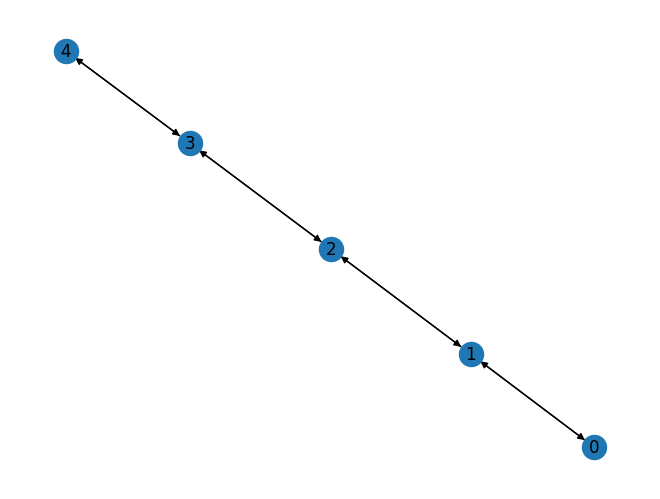

In [6]:
# Example usage
metadata = {"default_connectivity_radius": 1.6, "E_initial": 10, "P_initial": 0.5,
"node_features": ["x", "y", "load"], "edge_features": ["distance", "displacement", "E_edge"],
"node_input_size": 2, "edge_input_size": 4}
coordinates = [(0.5, 0), (1.5, 0), (2.5, 0), (3.5, 0), (4.5, 0)]
displacement = [0, 0.4, 0.5, 0.1]
graph_data = create_gnn_graph(coordinates, displacement_vector=displacement, metadata=metadata)

graph = to_networkx(graph_data)
nx.draw(graph, with_labels=True)
plt.show()


# Encoder

In [7]:
class Encoder(nn.Module):
    """ Encoder for the graph neural network. """

    def __init__(self,
                edge_input_size=4,
                node_input_size=2,
                hidden_size=128):
        super(Encoder, self).__init__()

        self.nb_encoder = build_mlp(node_input_size, hidden_size, hidden_size)
        self.eb_encoder = build_mlp(edge_input_size, hidden_size, hidden_size)

    def forward(self, graph):

        node_attr, _, edge_attr, _ = decompose_graph(graph)
        node_ = self.nb_encoder(node_attr)
        edge_ = self.eb_encoder(edge_attr)

        return Data(x=node_, edge_attr=edge_, edge_index=graph.edge_index)

In [8]:
decompose_graph(graph_data)

(tensor([[0.5000, 0.0000],
         [1.5000, 0.0000],
         [2.5000, 0.0000],
         [3.5000, 0.0000],
         [4.5000, 0.0000]]),
 tensor([[1, 0, 2, 1, 3, 2, 4, 3],
         [0, 1, 1, 2, 2, 3, 3, 4]]),
 tensor([[ 1.0000, -1.0000,  0.0000,  3.6884],
         [ 1.0000,  1.0000,  0.0000,  8.7237],
         [ 1.0000, -1.0000,  0.0000,  7.2176],
         [ 1.0000,  1.0000,  0.0000,  6.0512],
         [ 1.0000, -1.0000,  0.0000,  7.7445],
         [ 1.0000,  1.0000,  0.0000,  2.0115],
         [ 1.0000, -1.0000,  0.0000,  0.2984],
         [ 1.0000,  1.0000,  0.0000,  5.6113]]),
 None)

In [9]:
model = Encoder(edge_input_size=4, node_input_size=2, hidden_size=128)
out1 = model(graph_data)

# Decode

In [10]:
class Decoder(nn.Module):
    """ Decoder for the GNN model. """

    def __init__(self, hidden_size=128, output_size=2):
        super(Decoder, self).__init__()
        self.decode_module = build_mlp(hidden_size, hidden_size, output_size, lay_norm=False)

    def forward(self, graph):
        return self.decode_module(graph.x)

In [11]:
model = Decoder(hidden_size=128, output_size=2)
model(out1)

tensor([[-0.0047, -0.0119],
        [ 0.0063, -0.0116],
        [ 0.0054, -0.0038],
        [ 0.0112,  0.0010],
        [ 0.0123,  0.0091]], grad_fn=<AddmmBackward0>)

# GN Block

In [12]:
class GnBlock(nn.Module):
    """ Graph Neural Network Block """

    def __init__(self, hidden_size=128):

        super(GnBlock, self).__init__()
        eb_input_dim = 3 * hidden_size
        nb_input_dim = 2 * hidden_size
        nb_custom_func = build_mlp(nb_input_dim, hidden_size, hidden_size)
        eb_custom_func = build_mlp(eb_input_dim, hidden_size, hidden_size)

        self.eb_module = EdgeBlock(custom_func=eb_custom_func)
        self.nb_module = NodeBlock(custom_func=nb_custom_func)

    def forward(self, graph):

        graph_last = copy_geometric_data(graph)
        graph = self.eb_module(graph)
        graph = self.nb_module(graph)
        edge_attr = graph_last.edge_attr + graph.edge_attr
        x = graph_last.x + graph.x
        return Data(x=x, edge_attr=edge_attr, edge_index=graph.edge_index)

In [13]:
model = GnBlock(hidden_size=128)
model(out1)

Data(x=[5, 128], edge_index=[2, 8], edge_attr=[8, 128])

# Model

In [14]:
class EncoderProcesserDecoder(nn.Module):
    """ Encoder-Processer-Decoder model for GNN
    """

    def __init__(self, message_passing_num, node_input_size, edge_input_size, hidden_size=128):
        super(EncoderProcesserDecoder, self).__init__()
        self.encoder = Encoder(edge_input_size=edge_input_size, node_input_size=node_input_size, hidden_size=hidden_size)
        processer_list = []
        for _ in range(message_passing_num):
            processer_list.append(GnBlock(hidden_size=hidden_size))
        self.processer_list = nn.ModuleList(processer_list)

        self.decoder = Decoder(hidden_size=hidden_size, output_size=2)

    def forward(self, graph):

        graph= self.encoder(graph)
        for model in self.processer_list:
            graph = model(graph)
        decoded = self.decoder(graph)

        return decoded

In [15]:
model = EncoderProcesserDecoder(message_passing_num=3, node_input_size=2, edge_input_size=4, hidden_size=128)
model(graph_data)

tensor([[-0.0092,  0.0018],
        [-0.0008,  0.0248],
        [ 0.0043,  0.0280],
        [ 0.0070,  0.0347],
        [-0.0122,  0.0289]], grad_fn=<AddmmBackward0>)

# Simulator

In [16]:
class Simulator(nn.Module):
    """ Simulator model for the GNN

    Args:
        message_passing_num: int, number of message passing iterations
        node_input_size: int, size of the node input
        edge_input_size: int, size of the edge input
        device: torch.device, device to run the model
        model_dir: str, path to the model checkpoint
    """

    def __init__(self, message_passing_num, node_input_size, edge_input_size, device, model_dir='checkpoint/simulator.pth') -> None:
        super(Simulator, self).__init__()

        self.node_input_size =  node_input_size
        self.edge_input_size = edge_input_size
        self.model_dir = model_dir
        self.model = EncoderProcesserDecoder(message_passing_num=message_passing_num, node_input_size=node_input_size, edge_input_size=edge_input_size).to(device)

        print('Simulator model initialized')


    def forward(self, graph:Data):

        predicted = self.model(graph)
        target = graph.y

        return predicted, target

    def save(self):
        if self.model_dir is not None:
            os.makedirs(os.path.dirname(self.model_dir), exist_ok=True)

        torch.save(self.model.state_dict(), self.model_dir)

    def load(self):
        if self.model_dir is not None:
            self.model.load_state_dict(torch.load(self.model_dir))


In [17]:
model = Simulator(message_passing_num=3, node_input_size=2, edge_input_size=4, device=torch.device('cpu'))
A,B = model.forward(graph_data)

Simulator model initialized


# Training

In [19]:
import torch
from torch.optim.lr_scheduler import StepLR  # Import StepLR

dataset_dir = 'dataset'
batch_size = 20
noise_std=2e-2

print_batch = 10
save_batch = 200


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
simulator = Simulator(message_passing_num=3, node_input_size=2, edge_input_size=4, device=device)
optimizer = torch.optim.Adam(simulator.model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

print('Optimizer initialized')

Simulator model initialized
Optimizer initialized


In [20]:
import torch_geometric.transforms as T
transformer = T.Compose([T.FaceToEdge(), T.Cartesian(norm=False), T.Distance(norm=False)])

In [21]:
def loss_data(pred, target):
    return F.mse_loss(pred[:,0].unsqueeze(1), target)


In [184]:
import tqdm
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

def train(model: Simulator, dataloader, optimizer, scheduler, loss_fn, epochs=100, print_epoch=5, save_epoch=10):
    model.to(device)
    for batch_index, graph in enumerate(tqdm.tqdm(dataloader, desc="Batches")):
        for epoch in tqdm.tqdm(range(epochs), desc="Epochs", leave=False):
            epoch_loss = 0.0
        
            graph = graph.to(device)
            model.train()  # Ensure the model is in training mode
            pred, target = model(graph)
            loss = loss_fn(pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Print average loss for the epoch
            avg_loss = epoch_loss / len(dataloader)
            if epoch % print_epoch == 0:
                print(f'Epoch {epoch}, Average Loss: {avg_loss:.4f}')

            # Save the model at the end of each epoch
            if epoch % save_epoch == 0:
                model.save()
                print('Model saved')

            # Stop training if the loss is not decreasing
            if avg_loss < 1e-5:
                print('Stopping early due to low loss')
                break

        # Update the learning rate scheduler
        scheduler.step()

    print('Training complete')






# Dataloader

In [185]:
import pandas as pd

train_dataset_dir = 'data.json'
test_dataset_dir = r"data\JSON_Data_Updated\n=100_p=2_varying_l_vectors.json"


In [190]:
import pandas as pd
import numpy as np
from torch_geometric.data import Dataset
from torch_geometric.data import DataLoader

class GraphDataset(Dataset):
    def __init__(self, dataset_dir, metadata):
        self.df = pd.read_json(dataset_dir)
        #self.df = self.df.applymap(lambda x: np.array(x))
        self.metadata = metadata

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        displacement_y = self.df["Displacement"].iloc[idx]
        coordinates = self.df["Coord"].iloc[idx]
        EI = self.df["EI"].iloc[idx]
        self.metadata["default_connectivity_radius"] = np.hypot(*np.diff(coordinates, axis=0).T).mean() * 1.05
        #print(self.metadata["default_connectivity_radius"])
        graph_data = create_gnn_graph(coordinates, displacement_y, self.metadata)
        return graph_data


In [191]:
train_dataloader = DataLoader(GraphDataset(train_dataset_dir, metadata), batch_size=20, shuffle=True)
test_dataloader = DataLoader(GraphDataset(test_dataset_dir, metadata), batch_size=20, shuffle=True)

C:\Users\kurt-\AppData\Roaming\Python\Python312\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\kurt-\AppData\Roaming\Python\Python312\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Train test

In [192]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
simulator = Simulator(message_passing_num=3, node_input_size=2, edge_input_size=4, device=device)
optimizer = torch.optim.Adam(simulator.model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

cpu
Simulator model initialized


In [193]:
train(simulator, train_dataloader, optimizer, scheduler, loss_data, epochs=10)

Batches:   0%|          | 0/2500 [00:00<?, ?it/s]


Epoch 0, Average Loss: 0.0156
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00,  8.04it/s]

Epoch 5, Average Loss: 0.0151


Batches:   0%|          | 1/2500 [00:01<43:49,  1.05s/it]

Epoch 0, Average Loss: 0.2624
Model saved


Epoch 5, Average Loss: 0.2609


Batches:   0%|          | 2/2500 [00:01<39:17,  1.06it/s]

Epoch 0, Average Loss: 0.0914
Model saved


Epoch 5, Average Loss: 0.0901


Batches:   0%|          | 3/2500 [00:02<37:59,  1.10it/s]

Epoch 0, Average Loss: 0.0174
Model saved


Epoch 5, Average Loss: 0.0170


Batches:   0%|          | 4/2500 [00:03<36:46,  1.13it/s]

Epoch 0, Average Loss: 0.0022
Model saved


Epoch 5, Average Loss: 0.0018


Batches:   0%|          | 5/2500 [00:04<36:01,  1.15it/s]


Epoch 0, Average Loss: 0.0006
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00, 11.49it/s]

Epoch 5, Average Loss: 0.0006


Batches:   0%|          | 6/2500 [00:05<36:49,  1.13it/s]

Epoch 0, Average Loss: 0.0086
Model saved


Epoch 5, Average Loss: 0.0081


Batches:   0%|          | 7/2500 [00:06<36:04,  1.15it/s]

Epoch 0, Average Loss: 0.0380
Model saved


Epoch 5, Average Loss: 0.0360


Batches:   0%|          | 8/2500 [00:07<35:33,  1.17it/s]

Epoch 0, Average Loss: 2.6395
Model saved


Epoch 5, Average Loss: 2.6181


Batches:   0%|          | 9/2500 [00:07<35:50,  1.16it/s]

Epoch 0, Average Loss: 0.0091
Model saved


Epoch 5, Average Loss: 0.0021


Batches:   0%|          | 10/2500 [00:08<35:53,  1.16it/s]

Epoch 0, Average Loss: 0.0062
Model saved


Epoch 5, Average Loss: 0.0059


Batches:   0%|          | 11/2500 [00:09<36:58,  1.12it/s]

Epoch 0, Average Loss: 0.0112
Model saved


Epoch 5, Average Loss: 0.0109


Batches:   0%|          | 12/2500 [00:10<36:42,  1.13it/s]


Epoch 0, Average Loss: 0.0109
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00, 11.11it/s]

Epoch 5, Average Loss: 0.0107


Batches:   1%|          | 13/2500 [00:11<36:29,  1.14it/s]


Epoch 0, Average Loss: 0.0699
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00, 11.17it/s]

Epoch 5, Average Loss: 0.0693


Batches:   1%|          | 14/2500 [00:12<36:13,  1.14it/s]

Epoch 0, Average Loss: 0.0067
Model saved


Epoch 5, Average Loss: 0.0065


Batches:   1%|          | 15/2500 [00:13<36:25,  1.14it/s]

Epoch 0, Average Loss: 0.0127
Model saved


Epoch 5, Average Loss: 0.0125


Batches:   1%|          | 16/2500 [00:14<36:22,  1.14it/s]

Epoch 0, Average Loss: 0.0018
Model saved


Epoch 5, Average Loss: 0.0015


Batches:   1%|          | 17/2500 [00:15<37:15,  1.11it/s]

Epoch 0, Average Loss: 0.1860
Model saved


Epoch 5, Average Loss: 0.1844


Batches:   1%|          | 18/2500 [00:15<36:45,  1.13it/s]

Epoch 0, Average Loss: 0.0020
Model saved


Epoch 5, Average Loss: 0.0025


Batches:   1%|          | 19/2500 [00:16<36:32,  1.13it/s]

Epoch 0, Average Loss: 0.0134
Model saved


Epoch 5, Average Loss: 0.0133


Batches:   1%|          | 20/2500 [00:17<35:53,  1.15it/s]

Epoch 0, Average Loss: 0.0099
Model saved


Epoch 5, Average Loss: 0.0099


Batches:   1%|          | 21/2500 [00:18<35:39,  1.16it/s]

Epoch 0, Average Loss: 0.2226
Model saved


Epoch 5, Average Loss: 0.2225


Batches:   1%|          | 22/2500 [00:19<35:57,  1.15it/s]

Epoch 0, Average Loss: 0.0015
Model saved


Epoch 5, Average Loss: 0.0015


Batches:   1%|          | 23/2500 [00:20<36:11,  1.14it/s]

Epoch 0, Average Loss: 1.3638
Model saved


Epoch 5, Average Loss: 1.3622


Batches:   1%|          | 24/2500 [00:21<35:51,  1.15it/s]

Epoch 0, Average Loss: 0.0059
Model saved


Epoch 5, Average Loss: 0.0060


Epochs:  30%|███       | 3/10 [00:00<00:00,  9.74it/s]

Epoch 0, Average Loss: 0.0054
Model saved


Epoch 5, Average Loss: 0.0055


Batches:   1%|          | 26/2500 [00:22<36:33,  1.13it/s]

Epoch 0, Average Loss: 0.0277
Model saved


Epoch 5, Average Loss: 0.0277


Batches:   1%|          | 27/2500 [00:23<36:15,  1.14it/s]

Epoch 0, Average Loss: 0.3179
Model saved


Epoch 5, Average Loss: 0.3178


Batches:   1%|          | 28/2500 [00:24<36:24,  1.13it/s]

Epoch 0, Average Loss: 0.0498
Model saved


Epoch 5, Average Loss: 0.0498


Batches:   1%|          | 29/2500 [00:25<37:02,  1.11it/s]

Epoch 0, Average Loss: 0.0097
Model saved


Epoch 5, Average Loss: 0.0097


Batches:   1%|          | 30/2500 [00:26<37:17,  1.10it/s]

Epoch 0, Average Loss: 0.0045
Model saved


Epoch 5, Average Loss: 0.0045


Batches:   1%|          | 31/2500 [00:27<37:09,  1.11it/s]

Epoch 0, Average Loss: 0.0040
Model saved


Epoch 5, Average Loss: 0.0040


Batches:   1%|▏         | 32/2500 [00:28<36:23,  1.13it/s]


Epoch 0, Average Loss: 0.0522
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00, 11.14it/s]

Epoch 5, Average Loss: 0.0522


Batches:   1%|▏         | 33/2500 [00:29<36:01,  1.14it/s]

Epoch 0, Average Loss: 0.0081
Model saved


Epoch 5, Average Loss: 0.0081


Batches:   1%|▏         | 34/2500 [00:30<36:36,  1.12it/s]

Epoch 0, Average Loss: 0.0027
Model saved


Epoch 5, Average Loss: 0.0027


Batches:   1%|▏         | 35/2500 [00:30<36:05,  1.14it/s]

Epoch 0, Average Loss: 0.0451
Model saved


Epoch 5, Average Loss: 0.0451


Batches:   1%|▏         | 36/2500 [00:31<35:43,  1.15it/s]

Epoch 0, Average Loss: 0.0403
Model saved


Epoch 5, Average Loss: 0.0403


Batches:   1%|▏         | 37/2500 [00:32<35:20,  1.16it/s]

Epoch 0, Average Loss: 0.0034
Model saved


Epoch 5, Average Loss: 0.0034


Batches:   2%|▏         | 38/2500 [00:33<35:17,  1.16it/s]


Epoch 0, Average Loss: 4.3632
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00, 10.17it/s]

Epoch 5, Average Loss: 4.3631


Batches:   2%|▏         | 39/2500 [00:34<36:07,  1.14it/s]

Epoch 0, Average Loss: 0.4544
Model saved


Epoch 5, Average Loss: 0.4543


Batches:   2%|▏         | 40/2500 [00:35<35:44,  1.15it/s]


Epoch 0, Average Loss: 0.0038
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00, 11.13it/s]

Epoch 5, Average Loss: 0.0038


Batches:   2%|▏         | 41/2500 [00:36<35:33,  1.15it/s]

Epoch 0, Average Loss: 0.0034
Model saved


Epoch 5, Average Loss: 0.0034


Batches:   2%|▏         | 42/2500 [00:37<36:14,  1.13it/s]


Epoch 0, Average Loss: 0.0389
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00, 10.92it/s]

Epoch 5, Average Loss: 0.0389


Batches:   2%|▏         | 43/2500 [00:37<36:06,  1.13it/s]

Epoch 0, Average Loss: 0.0670
Model saved


Epoch 5, Average Loss: 0.0670


Batches:   2%|▏         | 44/2500 [00:38<35:41,  1.15it/s]

Epoch 0, Average Loss: 0.0084
Model saved


Epoch 5, Average Loss: 0.0084


Batches:   2%|▏         | 45/2500 [00:39<36:09,  1.13it/s]

Epoch 0, Average Loss: 0.1901
Model saved


Epoch 5, Average Loss: 0.1901


Batches:   2%|▏         | 46/2500 [00:40<36:20,  1.13it/s]

Epoch 0, Average Loss: 0.0390
Model saved


Epoch 5, Average Loss: 0.0390


Batches:   2%|▏         | 47/2500 [00:41<39:05,  1.05it/s]

Epoch 0, Average Loss: 0.0223
Model saved


Epoch 5, Average Loss: 0.0223


Batches:   2%|▏         | 48/2500 [00:42<38:49,  1.05it/s]

Epoch 0, Average Loss: 0.0025
Model saved


Epoch 5, Average Loss: 0.0025


Batches:   2%|▏         | 49/2500 [00:43<37:46,  1.08it/s]

Epoch 0, Average Loss: 0.0061
Model saved


Epoch 5, Average Loss: 0.0061


Batches:   2%|▏         | 50/2500 [00:44<37:15,  1.10it/s]

Epoch 0, Average Loss: 0.0032
Model saved


Epoch 5, Average Loss: 0.0032


Batches:   2%|▏         | 51/2500 [00:45<36:52,  1.11it/s]

Epoch 0, Average Loss: 0.0384
Model saved


Epoch 5, Average Loss: 0.0384


Batches:   2%|▏         | 52/2500 [00:46<36:56,  1.10it/s]


Epoch 0, Average Loss: 0.0049
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00, 10.77it/s]

Epoch 5, Average Loss: 0.0049


Batches:   2%|▏         | 53/2500 [00:47<37:01,  1.10it/s]

Epoch 0, Average Loss: 0.0059
Model saved


Epoch 5, Average Loss: 0.0059


Batches:   2%|▏         | 54/2500 [00:47<36:49,  1.11it/s]

Epoch 0, Average Loss: 0.1159
Model saved


Epoch 5, Average Loss: 0.1159


Batches:   2%|▏         | 55/2500 [00:48<36:20,  1.12it/s]

Epoch 0, Average Loss: 0.0136
Model saved


Epoch 5, Average Loss: 0.0136


Batches:   2%|▏         | 56/2500 [00:49<36:34,  1.11it/s]

Epoch 0, Average Loss: 1.4226
Model saved


Epoch 5, Average Loss: 1.4226


Batches:   2%|▏         | 57/2500 [00:50<36:36,  1.11it/s]

Epoch 0, Average Loss: 0.0970
Model saved


Epoch 5, Average Loss: 0.0970


Batches:   2%|▏         | 58/2500 [01:07<3:46:41,  5.57s/it]

Epoch 0, Average Loss: 0.0036
Model saved


Epoch 5, Average Loss: 0.0036


Batches:   2%|▏         | 59/2500 [01:08<2:50:08,  4.18s/it]

Epoch 0, Average Loss: 0.0219
Model saved


Epoch 5, Average Loss: 0.0219


Batches:   2%|▏         | 60/2500 [01:09<2:11:16,  3.23s/it]

Epoch 0, Average Loss: 0.0040
Model saved


Epoch 5, Average Loss: 0.0040


Batches:   2%|▏         | 61/2500 [01:09<1:42:59,  2.53s/it]

Epoch 0, Average Loss: 0.0226
Model saved


Epoch 5, Average Loss: 0.0226


Batches:   2%|▏         | 62/2500 [01:10<1:24:26,  2.08s/it]

Epoch 0, Average Loss: 0.0207
Model saved


Epoch 5, Average Loss: 0.0207


Batches:   3%|▎         | 63/2500 [01:11<1:10:30,  1.74s/it]

Epoch 0, Average Loss: 0.0043
Model saved


Epoch 5, Average Loss: 0.0043


Batches:   3%|▎         | 64/2500 [01:12<1:01:38,  1.52s/it]

Epoch 0, Average Loss: 0.0037
Model saved


Epoch 5, Average Loss: 0.0037


Epochs:  30%|███       | 3/10 [00:00<00:00, 10.83it/s]

Epoch 0, Average Loss: 0.1016
Model saved


Epoch 5, Average Loss: 0.1016


Batches:   3%|▎         | 66/2500 [01:14<50:38,  1.25s/it]

Epoch 0, Average Loss: 0.0443
Model saved


Epoch 5, Average Loss: 0.0443


Batches:   3%|▎         | 67/2500 [01:16<49:25,  1.22s/it]

Epoch 0, Average Loss: 0.0023
Model saved


Epoch 5, Average Loss: 0.0023


Batches:   3%|▎         | 68/2500 [01:17<47:11,  1.16s/it]

Epoch 0, Average Loss: 0.0044
Model saved


Epoch 5, Average Loss: 0.0044


Batches:   3%|▎         | 69/2500 [01:18<46:55,  1.16s/it]

Epoch 0, Average Loss: 0.0132
Model saved


Epoch 5, Average Loss: 0.0132


Batches:   3%|▎         | 70/2500 [01:19<44:22,  1.10s/it]

Epoch 0, Average Loss: 0.0022
Model saved


Epoch 5, Average Loss: 0.0022


Batches:   3%|▎         | 71/2500 [01:20<42:56,  1.06s/it]


Epoch 0, Average Loss: 2.1394
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00, 10.35it/s]

Epoch 5, Average Loss: 2.1394


Batches:   3%|▎         | 72/2500 [01:21<43:24,  1.07s/it]

Epoch 0, Average Loss: 0.0149
Model saved


Epoch 5, Average Loss: 0.0149


Batches:   3%|▎         | 73/2500 [01:22<43:15,  1.07s/it]

Epoch 0, Average Loss: 0.0363
Model saved


Epoch 5, Average Loss: 0.0363


Batches:   3%|▎         | 74/2500 [01:23<43:16,  1.07s/it]


Epoch 0, Average Loss: 0.4249
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00, 10.90it/s]

Epoch 5, Average Loss: 0.4249


Batches:   3%|▎         | 75/2500 [01:24<43:24,  1.07s/it]

Epoch 0, Average Loss: 0.0166
Model saved


Epoch 5, Average Loss: 0.0166


Batches:   3%|▎         | 76/2500 [01:25<42:08,  1.04s/it]

Epoch 0, Average Loss: 0.0842
Model saved


Epoch 5, Average Loss: 0.0842


Batches:   3%|▎         | 77/2500 [01:26<42:56,  1.06s/it]

Epoch 0, Average Loss: 0.0250
Model saved


Epoch 5, Average Loss: 0.0250


Batches:   3%|▎         | 78/2500 [01:27<42:13,  1.05s/it]

Epoch 0, Average Loss: 0.1309
Model saved


Epoch 5, Average Loss: 0.1309


Batches:   3%|▎         | 79/2500 [01:28<41:48,  1.04s/it]

Epoch 0, Average Loss: 0.0030
Model saved


Epoch 5, Average Loss: 0.0030


Batches:   3%|▎         | 80/2500 [01:29<41:00,  1.02s/it]

Epoch 0, Average Loss: 0.3250
Model saved


Epoch 5, Average Loss: 0.3250


Batches:   3%|▎         | 81/2500 [01:30<39:48,  1.01it/s]

Epoch 0, Average Loss: 0.0054
Model saved


Epoch 5, Average Loss: 0.0054


Batches:   3%|▎         | 82/2500 [01:31<41:29,  1.03s/it]

Epoch 0, Average Loss: 0.0632
Model saved


Epoch 5, Average Loss: 0.0632


Batches:   3%|▎         | 83/2500 [01:32<41:15,  1.02s/it]

Epoch 0, Average Loss: 0.0040
Model saved


Epoch 5, Average Loss: 0.0040


Batches:   3%|▎         | 84/2500 [01:33<41:39,  1.03s/it]

Epoch 0, Average Loss: 0.1321
Model saved


Epoch 5, Average Loss: 0.1321


Batches:   3%|▎         | 85/2500 [01:34<41:17,  1.03s/it]

Epoch 0, Average Loss: 0.0082
Model saved


Epoch 5, Average Loss: 0.0082


Batches:   3%|▎         | 86/2500 [01:35<42:15,  1.05s/it]


Epoch 0, Average Loss: 0.0039
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00, 11.03it/s]


Epoch 5, Average Loss: 0.0039


Batches:   3%|▎         | 87/2500 [01:36<42:21,  1.05s/it]


Epoch 0, Average Loss: 0.0231
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00, 10.29it/s]

Epoch 5, Average Loss: 0.0231


Batches:   4%|▎         | 88/2500 [01:37<42:48,  1.06s/it]

Epoch 0, Average Loss: 0.0380
Model saved


Epoch 5, Average Loss: 0.0380


Batches:   4%|▎         | 89/2500 [01:39<43:32,  1.08s/it]

Epoch 0, Average Loss: 0.0115
Model saved


Epoch 5, Average Loss: 0.0115


Batches:   4%|▎         | 90/2500 [01:40<44:27,  1.11s/it]

Epoch 0, Average Loss: 0.0756


Model saved


Epoch 5, Average Loss: 0.0756


Batches:   4%|▎         | 91/2500 [01:41<51:34,  1.28s/it]


Epoch 0, Average Loss: 0.0850
Model saved


Epochs:  20%|██        | 2/10 [00:00<00:01,  5.68it/s]

Epoch 5, Average Loss: 0.0850


Batches:   4%|▎         | 92/2500 [01:43<50:34,  1.26s/it]

Epoch 0, Average Loss: 0.0432
Model saved


Epoch 5, Average Loss: 0.0432


Batches:   4%|▎         | 93/2500 [01:44<50:27,  1.26s/it]

Epoch 0, Average Loss: 0.0042
Model saved


Epoch 5, Average Loss: 0.0042


Batches:   4%|▍         | 94/2500 [01:45<50:35,  1.26s/it]


Epoch 0, Average Loss: 0.0094
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00, 11.42it/s]

Epoch 5, Average Loss: 0.0094


Batches:   4%|▍         | 95/2500 [01:46<48:27,  1.21s/it]

Epoch 0, Average Loss: 0.0401
Model saved


Epoch 5, Average Loss: 0.0401


Batches:   4%|▍         | 96/2500 [01:47<46:17,  1.16s/it]

Epoch 0, Average Loss: 0.0154
Model saved


Epoch 5, Average Loss: 0.0154


Batches:   4%|▍         | 97/2500 [01:48<46:28,  1.16s/it]


Epoch 0, Average Loss: 0.0086
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00, 10.85it/s]


Epoch 5, Average Loss: 0.0086


Batches:   4%|▍         | 98/2500 [01:49<45:06,  1.13s/it]

Epoch 0, Average Loss: 0.0041
Model saved


Epoch 5, Average Loss: 0.0041


Batches:   4%|▍         | 99/2500 [01:50<42:37,  1.07s/it]

Epoch 0, Average Loss: 0.0208
Model saved



Epochs:  80%|████████  | 8/10 [00:00<00:00, 10.42it/s]

Epoch 5, Average Loss: 0.0208


Batches:   4%|▍         | 100/2500 [01:51<42:52,  1.07s/it]

Epoch 0, Average Loss: 0.0055
Model saved


Epoch 5, Average Loss: 0.0055


Batches:   4%|▍         | 101/2500 [01:53<43:05,  1.08s/it]

Epoch 0, Average Loss: 0.0090
Model saved


Epoch 5, Average Loss: 0.0090


Batches:   4%|▍         | 102/2500 [01:53<40:47,  1.02s/it]

Epoch 0, Average Loss: 0.0615
Model saved


Epoch 5, Average Loss: 0.0615


Batches:   4%|▍         | 103/2500 [02:11<3:54:09,  5.86s/it]

Epoch 0, Average Loss: 0.2874
Model saved


Epoch 5, Average Loss: 0.2874


Batches:   4%|▍         | 104/2500 [02:12<2:56:13,  4.41s/it]

Epoch 0, Average Loss: 0.0060
Model saved


Epoch 5, Average Loss: 0.0060


Batches:   4%|▍         | 105/2500 [02:13<2:16:35,  3.42s/it]

Epoch 0, Average Loss: 0.2075
Model saved


Epoch 5, Average Loss: 0.2075


Batches:   4%|▍         | 106/2500 [02:14<1:48:52,  2.73s/it]

Epoch 0, Average Loss: 0.1398
Model saved


Epoch 5, Average Loss: 0.1398


Batches:   4%|▍         | 107/2500 [02:15<1:29:52,  2.25s/it]

Epoch 0, Average Loss: 0.0833
Model saved


Epoch 5, Average Loss: 0.0833


Batches:   4%|▍         | 108/2500 [02:16<1:15:05,  1.88s/it]

Epoch 0, Average Loss: 0.0027
Model saved


Epoch 5, Average Loss: 0.0027


Batches:   4%|▍         | 109/2500 [02:17<1:05:17,  1.64s/it]

Epoch 0, Average Loss: 0.0214
Model saved


Epoch 5, Average Loss: 0.0214


Batches:   4%|▍         | 110/2500 [02:18<57:58,  1.46s/it]  

Epoch 0, Average Loss: 0.0136
Model saved


Epoch 5, Average Loss: 0.0136


Batches:   4%|▍         | 111/2500 [02:19<51:42,  1.30s/it]

Epoch 0, Average Loss: 0.0042
Model saved


Epoch 5, Average Loss: 0.0042


Batches:   4%|▍         | 112/2500 [02:20<48:49,  1.23s/it]

Epoch 0, Average Loss: 0.0176
Model saved


Epoch 5, Average Loss: 0.0176


Batches:   5%|▍         | 113/2500 [02:21<46:55,  1.18s/it]

Epoch 0, Average Loss: 0.0049
Model saved


Epoch 5, Average Loss: 0.0049


Batches:   5%|▍         | 114/2500 [02:22<45:32,  1.15s/it]

Epoch 0, Average Loss: 0.1707
Model saved


Epoch 5, Average Loss: 0.1707


Batches:   5%|▍         | 115/2500 [02:23<43:27,  1.09s/it]

Epoch 0, Average Loss: 0.0535
Model saved


Epoch 5, Average Loss: 0.0535


Batches:   5%|▍         | 116/2500 [02:24<43:04,  1.08s/it]

Epoch 0, Average Loss: 0.1247
Model saved


Epoch 5, Average Loss: 0.1247


Batches:   5%|▍         | 117/2500 [02:26<45:05,  1.14s/it]

Epoch 0, Average Loss: 0.1912
Model saved


Epoch 5, Average Loss: 0.1912


Batches:   5%|▍         | 118/2500 [02:27<46:35,  1.17s/it]

Epoch 0, Average Loss: 0.0025
Model saved


Epoch 5, Average Loss: 0.0025


Batches:   5%|▍         | 119/2500 [02:28<45:31,  1.15s/it]

Epoch 0, Average Loss: 0.1683
Model saved


Epoch 5, Average Loss: 0.1683


Batches:   5%|▍         | 120/2500 [02:29<47:50,  1.21s/it]

Epoch 0, Average Loss: 0.0919
Model saved


Epoch 5, Average Loss: 0.0919


Batches:   5%|▍         | 121/2500 [02:30<47:21,  1.19s/it]

Epoch 0, Average Loss: 0.0095
Model saved


Epoch 5, Average Loss: 0.0095


Batches:   5%|▍         | 122/2500 [02:31<45:17,  1.14s/it]

Epoch 0, Average Loss: 0.0082
Model saved


Epoch 5, Average Loss: 0.0082


Batches:   5%|▍         | 123/2500 [02:33<45:37,  1.15s/it]

Epoch 0, Average Loss: 0.0101
Model saved


Epoch 5, Average Loss: 0.0101


Batches:   5%|▍         | 124/2500 [02:34<45:39,  1.15s/it]

Epoch 0, Average Loss: 0.0559
Model saved


Epoch 5, Average Loss: 0.0559


Batches:   5%|▌         | 125/2500 [02:35<46:54,  1.18s/it]


Epoch 0, Average Loss: 0.0369
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00,  9.86it/s]

Epoch 5, Average Loss: 0.0369


Batches:   5%|▌         | 126/2500 [02:36<44:37,  1.13s/it]

Epoch 0, Average Loss: 0.0387
Model saved


Epoch 5, Average Loss: 0.0387


Batches:   5%|▌         | 127/2500 [02:37<41:29,  1.05s/it]

Epoch 0, Average Loss: 0.1052
Model saved


Epoch 5, Average Loss: 0.1052


Batches:   5%|▌         | 128/2500 [02:38<42:13,  1.07s/it]

Epoch 0, Average Loss: 0.1320
Model saved


Epoch 5, Average Loss: 0.1320


Batches:   5%|▌         | 129/2500 [02:39<40:54,  1.04s/it]

Epoch 0, Average Loss: 0.0220
Model saved


Epoch 5, Average Loss: 0.0220


Batches:   5%|▌         | 130/2500 [02:40<40:50,  1.03s/it]

Epoch 0, Average Loss: 0.0666
Model saved


Epoch 5, Average Loss: 0.0666


Batches:   5%|▌         | 131/2500 [02:41<41:01,  1.04s/it]

Epoch 0, Average Loss: 0.0109
Model saved


Epoch 5, Average Loss: 0.0109


Batches:   5%|▌         | 132/2500 [02:42<41:56,  1.06s/it]

Epoch 0, Average Loss: 0.0044
Model saved


Epoch 5, Average Loss: 0.0044


Batches:   5%|▌         | 133/2500 [02:43<40:25,  1.02s/it]

Epoch 0, Average Loss: 0.4560
Model saved


Epoch 5, Average Loss: 0.4560


Batches:   5%|▌         | 134/2500 [02:44<42:41,  1.08s/it]

Epoch 0, Average Loss: 0.0026
Model saved


Epoch 5, Average Loss: 0.0026


Epochs:  30%|███       | 3/10 [00:00<00:00, 10.88it/s]

Epoch 0, Average Loss: 0.0038
Model saved


Epoch 5, Average Loss: 0.0038


Batches:   5%|▌         | 136/2500 [02:46<41:18,  1.05s/it]

Epoch 0, Average Loss: 0.0179
Model saved


Epoch 5, Average Loss: 0.0179


Batches:   5%|▌         | 137/2500 [02:47<41:31,  1.05s/it]

Epoch 0, Average Loss: 0.0109
Model saved


Epoch 5, Average Loss: 0.0109


Batches:   6%|▌         | 138/2500 [02:49<42:28,  1.08s/it]

Epoch 0, Average Loss: 0.0032
Model saved


Epoch 5, Average Loss: 0.0032


Batches:   6%|▌         | 139/2500 [02:50<41:18,  1.05s/it]

Epoch 0, Average Loss: 2.0205
Model saved


Epoch 5, Average Loss: 2.0205


Batches:   6%|▌         | 140/2500 [02:51<42:28,  1.08s/it]

Epoch 0, Average Loss: 0.0028
Model saved


Epoch 5, Average Loss: 0.0028


Batches:   6%|▌         | 141/2500 [02:52<42:07,  1.07s/it]

Epoch 0, Average Loss: 0.0213
Model saved


Epoch 5, Average Loss: 0.0213


Batches:   6%|▌         | 142/2500 [02:53<43:13,  1.10s/it]

Epoch 0, Average Loss: 0.0022
Model saved


Epoch 5, Average Loss: 0.0022


Batches:   6%|▌         | 143/2500 [02:54<42:12,  1.07s/it]

Epoch 0, Average Loss: 2.1149
Model saved


Epoch 5, Average Loss: 2.1149


Batches:   6%|▌         | 144/2500 [02:55<40:28,  1.03s/it]

Epoch 0, Average Loss: 0.0032
Model saved


Epoch 5, Average Loss: 0.0032


Batches:   6%|▌         | 145/2500 [02:56<41:35,  1.06s/it]

Epoch 0, Average Loss: 0.1128
Model saved


Epoch 5, Average Loss: 0.1128


Batches:   6%|▌         | 146/2500 [02:57<41:44,  1.06s/it]


Epoch 0, Average Loss: 0.0148
Model saved


Epochs:  30%|███       | 3/10 [00:00<00:00,  9.57it/s]

Epoch 5, Average Loss: 0.0148


Batches:   6%|▌         | 147/2500 [02:58<42:48,  1.09s/it]

Epoch 0, Average Loss: 0.0038
Model saved


Epoch 5, Average Loss: 0.0038


Epochs:  20%|██        | 2/10 [00:00<00:01,  6.25it/s]

Epoch 0, Average Loss: 0.0053
Model saved


Epoch 5, Average Loss: 0.0053


Batches:   6%|▌         | 149/2500 [03:25<5:33:44,  8.52s/it]

Epoch 0, Average Loss: 0.0189
Model saved


Epoch 5, Average Loss: 0.0189


Batches:   6%|▌         | 150/2500 [03:56<9:51:12, 15.09s/it]

Epoch 0, Average Loss: 0.0280
Model saved


Epoch 5, Average Loss: 0.0280


Batches:   6%|▌         | 151/2500 [04:00<7:49:20, 11.99s/it]

Epoch 0, Average Loss: 0.2347
Model saved


Epoch 5, Average Loss: 0.2347


Batches:   6%|▌         | 152/2500 [04:01<5:41:17,  8.72s/it]

Epoch 0, Average Loss: 0.0029
Model saved


Epoch 5, Average Loss: 0.0029


Batches:   6%|▌         | 153/2500 [04:02<4:10:51,  6.41s/it]

Epoch 0, Average Loss: 0.0120
Model saved


Epoch 5, Average Loss: 0.0120


Batches:   6%|▌         | 154/2500 [04:04<3:09:12,  4.84s/it]

Epoch 0, Average Loss: 0.0111
Model saved


Epoch 5, Average Loss: 0.0111


Batches:   6%|▌         | 155/2500 [04:05<2:24:29,  3.70s/it]

Epoch 0, Average Loss: 0.3646
Model saved


Epoch 5, Average Loss: 0.3646


Batches:   6%|▌         | 156/2500 [04:06<1:53:22,  2.90s/it]

Epoch 0, Average Loss: 0.0053
Model saved


Epoch 5, Average Loss: 0.0053


Batches:   6%|▋         | 157/2500 [04:07<1:34:08,  2.41s/it]

Epoch 0, Average Loss: 0.0088
Model saved


Epoch 5, Average Loss: 0.0088


Batches:   6%|▋         | 157/2500 [04:08<1:01:46,  1.58s/it]


KeyboardInterrupt: 

In [ ]:
def test(model:Simulator, dataloader):
    loss = 0
    for batch_index, graph in enumerate(dataloader):
        model.eval()
        graph = graph.to(device)
        target = graph.y
        pred, target = model(graph)
        loss += loss_data(pred, target).item()

    return loss / len(dataloader)

test(simulator, test_dataloader)

6.936057752682246e-06

# Result

In [ ]:
simulator.model(test_dataloader[0])

tensor([[ 1.6724e-03, -1.7975e-02],
        [-2.7658e-04, -2.0745e-02],
        [-1.5717e-03, -2.3364e-02],
        [-5.2521e-04, -2.4693e-02],
        [ 5.9727e-04, -2.6182e-02],
        [-4.2909e-04, -2.8736e-02],
        [ 1.0535e-03, -2.8394e-02],
        [ 7.2690e-04, -3.0808e-02],
        [ 4.9762e-04, -3.2547e-02],
        [ 9.9119e-04, -3.3416e-02],
        [ 1.3252e-03, -3.3591e-02],
        [ 1.7196e-03, -3.4304e-02],
        [ 4.6014e-04, -3.4623e-02],
        [-1.1167e-03, -3.6241e-02],
        [-2.9059e-03, -3.6551e-02],
        [-2.5847e-03, -3.6126e-02],
        [-2.5618e-03, -3.6119e-02],
        [-3.3104e-03, -3.6294e-02],
        [-3.3116e-03, -3.5424e-02],
        [-3.0289e-03, -3.5395e-02],
        [-3.5131e-03, -3.5563e-02],
        [-3.5332e-03, -3.4146e-02],
        [-4.2083e-03, -3.2117e-02],
        [-3.4441e-03, -3.3090e-02],
        [-3.4952e-03, -3.3134e-02],
        [-3.3769e-03, -3.3985e-02],
        [-3.3136e-03, -3.4446e-02],
        [-3.5230e-03, -3.615

In [ ]:
# Create a function to plot the graph.x vs graph.y
def plot_results(model, dataloader):
    for batch_index, graph in enumerate(dataloader):
        graph = graph.to(device)
        pred, target = model(graph)
        pred = pred.detach().cpu().numpy()
        target = target.detach().cpu().numpy()
        x_coord = graph.x[:,0].detach().cpu().numpy()
        plt.plot(x_coord, target, label='target', marker='x')
        plt.plot(x_coord, pred[:,0], label='predicted', marker='o')
        plt.legend()
        plt.show()


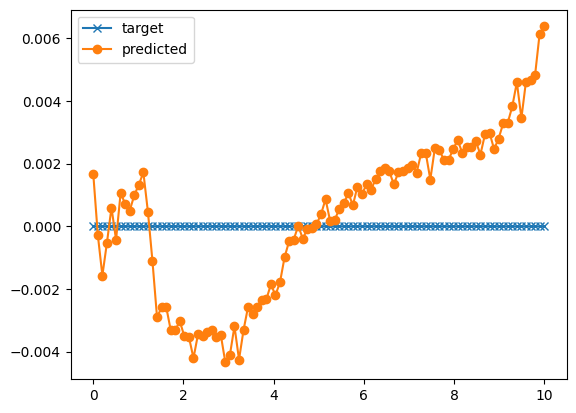

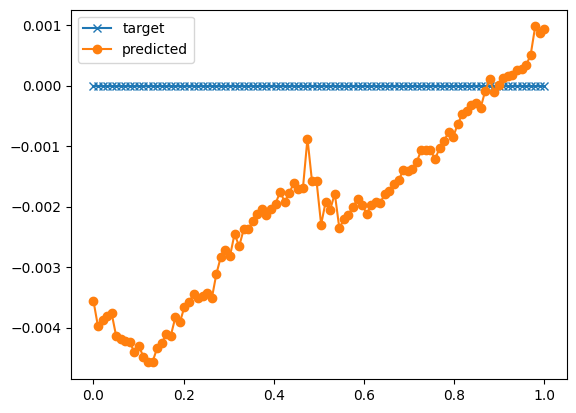

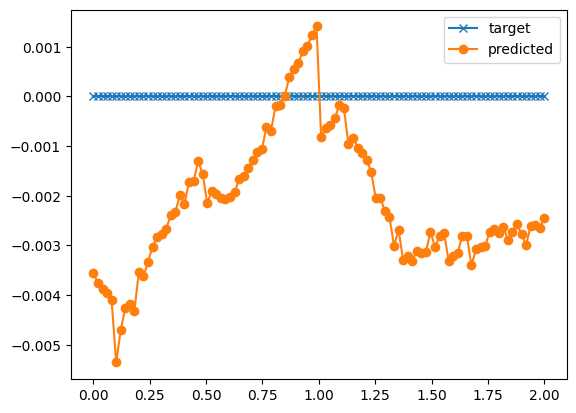

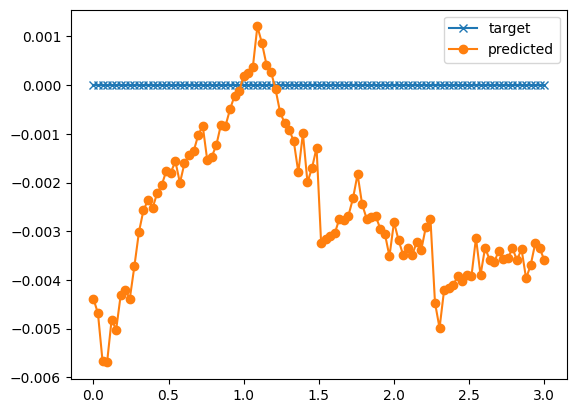

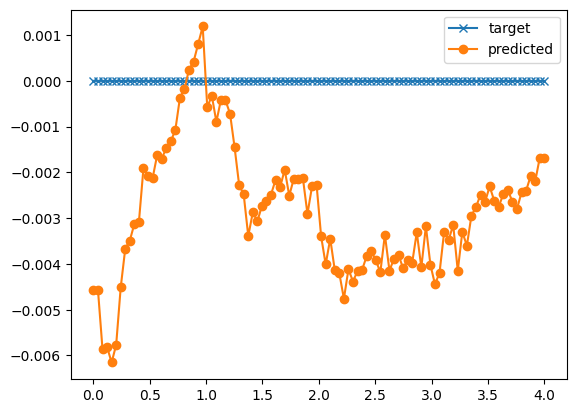

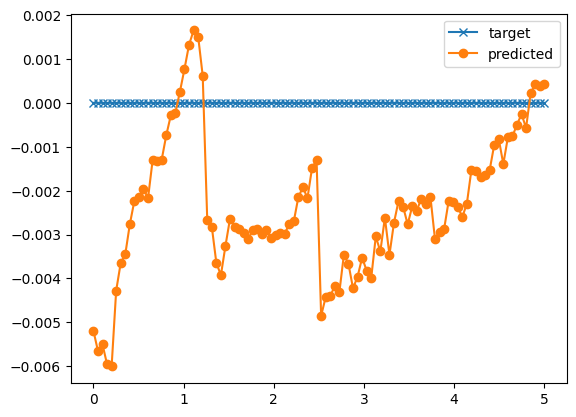

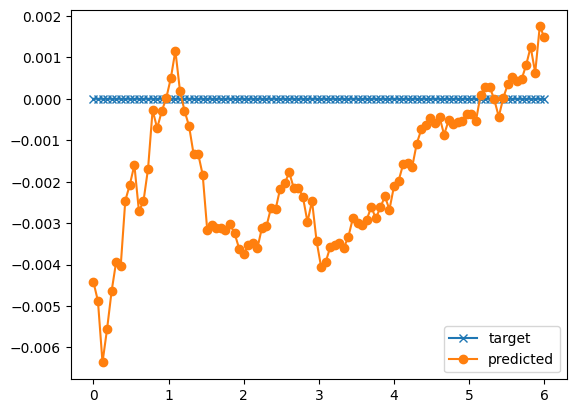

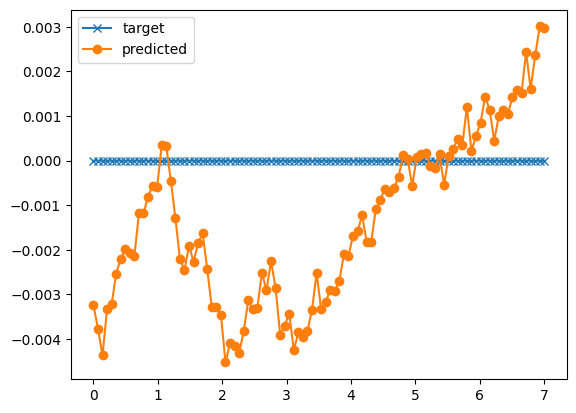

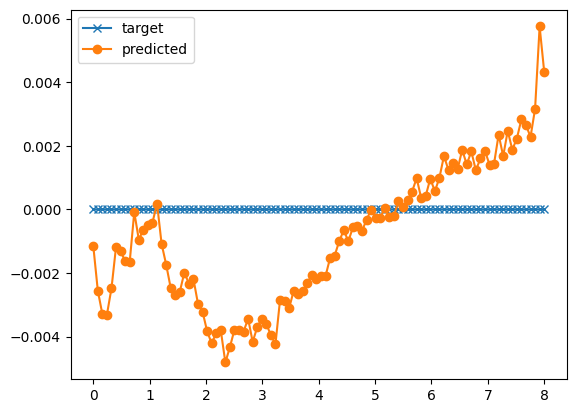

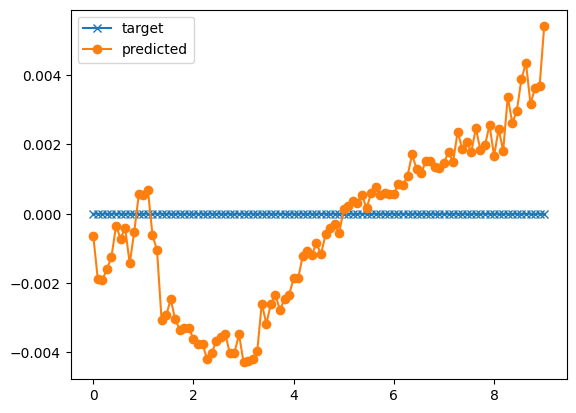

In [ ]:
plot_results(simulator, test_dataloader)

# Do PINN

In [ ]:
def loss_PDE(x, pred, q=torch.tensor(0.0)):
    x.requires_grad = True
    EI = pred[:,1]
    u = pred[:,0].unsqueeze(1)
    u_x = torch.autograd.grad(u, x, create_graph=True, grad_outputs=torch.ones_like(u), allow_unused=True)[0][:,0]
    u_xx = torch.autograd.grad(u_x, x, create_graph=True, grad_outputs=torch.ones_like(u_x), allow_unused=True)[0][:,0]
    u_xxx = torch.autograd.grad(u_xx, x, create_graph=True, grad_outputs=torch.ones_like(u_xx), allow_unused=True)[0][:,0]
    u_x4 = torch.autograd.grad(u_xxx, x, create_graph=True, grad_outputs=torch.ones_like(u_xxx), allow_unused=True)[0][:,0]

    # PDE
    fn = EI*u_x4 - q
    return torch.mean(fn**2)

def loss_data(pred, target):
    return F.mse_loss(pred[:,0].unsqueeze(1), target)

def loss_BC(w):
    fn = w[0] - 0.0
    return torch.mean(fn**2)

def loss_total(x, pred, target, q=torch.tensor(0.0)):
    return loss_PDE(x, pred, q) + loss_data(pred, target) + loss_BC(pred[:,0])

In [ ]:
pred, target = simulator(test_dataloader[0])
loss_total(test_dataloader[0].x, pred, target)

tensor(9.4614e-06, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
import torch.nn.functional as F

def train_PDE(model, dataloader, optimizer, scheduler=None, epochs=100, print_batch=5, save_batch=10):
  model.to(device)
  for batch_index, graph in enumerate(tqdm.tqdm(dataloader, desc="Batches")):
      for epoch in tqdm.tqdm(range(epochs), desc="Epochs", leave=False):
          graph = graph.to(device)
          model.train()  # Ensure the model is in training mode
          pred, target = model(graph)
          loss = F.mse_loss(pred, target)

          # Ensure loss is a scalar
          if loss.dim() > 0:
              loss = loss.mean()

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          if scheduler:
              scheduler.step()  # Update the learning rate if scheduler is provided

          if batch_index % print_batch == 0:
              print(f'Batch {batch_index}, Epoch {epoch} [Loss: {loss.item():.2e}]')

          if batch_index % save_batch == 0:
              model.save()
              #print('Model saved')


# Example usage with a learning rate scheduler
from torch.optim.lr_scheduler import StepLR

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

train_PDE(model, train_dataloader, optimizer, scheduler)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-162-5ee7e6d9037f>:10: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred, target)

Epochs:   3%|▎         | 3/100 [00:00<00:04, 23.96it/s]

Batch 0, Epoch 0 [Loss: 5.58e-06]
Batch 0, Epoch 1 [Loss: 9.11e-05]
Batch 0, Epoch 2 [Loss: 2.13e-05]
Batch 0, Epoch 3 [Loss: 8.91e-05]
Batch 0, Epoch 4 [Loss: 2.50e-05]
Batch 0, Epoch 5 [Loss: 6.07e-06]



Epochs:  12%|█▏        | 12/100 [00:00<00:03, 26.79it/s]

Batch 0, Epoch 6 [Loss: 3.82e-05]
Batch 0, Epoch 7 [Loss: 4.32e-05]
Batch 0, Epoch 8 [Loss: 1.30e-05]
Batch 0, Epoch 9 [Loss: 8.68e-07]
Batch 0, Epoch 10 [Loss: 1.69e-05]
Batch 0, Epoch 11 [Loss: 1.75e-05]



Epochs:  15%|█▌        | 15/100 [00:00<00:03, 27.00it/s]


Batch 0, Epoch 12 [Loss: 1.65e-05]
Batch 0, Epoch 13 [Loss: 1.41e-05]
Batch 0, Epoch 14 [Loss: 1.11e-05]
Batch 0, Epoch 15 [Loss: 7.90e-06]
Batch 0, Epoch 16 [Loss: 4.99e-06]
Batch 0, Epoch 17 [Loss: 2.68e-06]


Epochs:  24%|██▍       | 24/100 [00:00<00:02, 27.47it/s]

Batch 0, Epoch 18 [Loss: 1.13e-06]
Batch 0, Epoch 19 [Loss: 3.90e-07]
Batch 0, Epoch 20 [Loss: 3.64e-07]
Batch 0, Epoch 21 [Loss: 3.91e-07]
Batch 0, Epoch 22 [Loss: 4.16e-07]
Batch 0, Epoch 23 [Loss: 4.38e-07]



Epochs:  30%|███       | 30/100 [00:01<00:02, 27.88it/s]

Batch 0, Epoch 24 [Loss: 4.57e-07]
Batch 0, Epoch 25 [Loss: 4.72e-07]
Batch 0, Epoch 26 [Loss: 4.83e-07]
Batch 0, Epoch 27 [Loss: 4.91e-07]
Batch 0, Epoch 28 [Loss: 4.95e-07]
Batch 0, Epoch 29 [Loss: 4.96e-07]



Epochs:  33%|███▎      | 33/100 [00:01<00:02, 26.80it/s]

Batch 0, Epoch 30 [Loss: 4.94e-07]
Batch 0, Epoch 31 [Loss: 4.94e-07]
Batch 0, Epoch 32 [Loss: 4.93e-07]
Batch 0, Epoch 33 [Loss: 4.92e-07]
Batch 0, Epoch 34 [Loss: 4.90e-07]
Batch 0, Epoch 35 [Loss: 4.89e-07]



Epochs:  39%|███▉      | 39/100 [00:01<00:02, 24.66it/s]

Batch 0, Epoch 36 [Loss: 4.87e-07]
Batch 0, Epoch 37 [Loss: 4.84e-07]
Batch 0, Epoch 38 [Loss: 4.82e-07]
Batch 0, Epoch 39 [Loss: 4.79e-07]
Batch 0, Epoch 40 [Loss: 4.77e-07]
Batch 0, Epoch 41 [Loss: 4.76e-07]



Epochs:  45%|████▌     | 45/100 [00:01<00:02, 21.46it/s]

Batch 0, Epoch 42 [Loss: 4.76e-07]
Batch 0, Epoch 43 [Loss: 4.76e-07]
Batch 0, Epoch 44 [Loss: 4.76e-07]
Batch 0, Epoch 45 [Loss: 4.76e-07]



Epochs:  51%|█████     | 51/100 [00:02<00:02, 22.34it/s]

Batch 0, Epoch 46 [Loss: 4.75e-07]
Batch 0, Epoch 47 [Loss: 4.75e-07]
Batch 0, Epoch 48 [Loss: 4.75e-07]
Batch 0, Epoch 49 [Loss: 4.75e-07]
Batch 0, Epoch 50 [Loss: 4.74e-07]
Batch 0, Epoch 51 [Loss: 4.74e-07]


Epochs:  54%|█████▍    | 54/100 [00:02<00:02, 22.58it/s]


Batch 0, Epoch 52 [Loss: 4.74e-07]
Batch 0, Epoch 53 [Loss: 4.74e-07]
Batch 0, Epoch 54 [Loss: 4.74e-07]
Batch 0, Epoch 55 [Loss: 4.74e-07]



Epochs:  60%|██████    | 60/100 [00:02<00:01, 23.03it/s]

Batch 0, Epoch 56 [Loss: 4.74e-07]
Batch 0, Epoch 57 [Loss: 4.74e-07]
Batch 0, Epoch 58 [Loss: 4.74e-07]
Batch 0, Epoch 59 [Loss: 4.74e-07]
Batch 0, Epoch 60 [Loss: 4.74e-07]
Batch 0, Epoch 61 [Loss: 4.74e-07]



Epochs:  68%|██████▊   | 68/100 [00:02<00:01, 29.31it/s]

Batch 0, Epoch 62 [Loss: 4.74e-07]
Batch 0, Epoch 63 [Loss: 4.74e-07]
Batch 0, Epoch 64 [Loss: 4.74e-07]
Batch 0, Epoch 65 [Loss: 4.74e-07]
Batch 0, Epoch 66 [Loss: 4.74e-07]
Batch 0, Epoch 67 [Loss: 4.74e-07]
Batch 0, Epoch 68 [Loss: 4.74e-07]
Batch 0, Epoch 69 [Loss: 4.74e-07]



Epochs:  76%|███████▌  | 76/100 [00:02<00:00, 33.48it/s]

Batch 0, Epoch 70 [Loss: 4.74e-07]
Batch 0, Epoch 71 [Loss: 4.74e-07]
Batch 0, Epoch 72 [Loss: 4.74e-07]
Batch 0, Epoch 73 [Loss: 4.74e-07]
Batch 0, Epoch 74 [Loss: 4.74e-07]
Batch 0, Epoch 75 [Loss: 4.74e-07]
Batch 0, Epoch 76 [Loss: 4.74e-07]
Batch 0, Epoch 77 [Loss: 4.74e-07]



Epochs:  84%|████████▍ | 84/100 [00:03<00:00, 35.83it/s]

Batch 0, Epoch 78 [Loss: 4.74e-07]
Batch 0, Epoch 79 [Loss: 4.74e-07]
Batch 0, Epoch 80 [Loss: 4.74e-07]
Batch 0, Epoch 81 [Loss: 4.74e-07]
Batch 0, Epoch 82 [Loss: 4.74e-07]
Batch 0, Epoch 83 [Loss: 4.74e-07]
Batch 0, Epoch 84 [Loss: 4.74e-07]
Batch 0, Epoch 85 [Loss: 4.74e-07]



Epochs:  92%|█████████▏| 92/100 [00:03<00:00, 36.31it/s]

Batch 0, Epoch 86 [Loss: 4.74e-07]
Batch 0, Epoch 87 [Loss: 4.74e-07]
Batch 0, Epoch 88 [Loss: 4.74e-07]
Batch 0, Epoch 89 [Loss: 4.74e-07]
Batch 0, Epoch 90 [Loss: 4.74e-07]
Batch 0, Epoch 91 [Loss: 4.74e-07]
Batch 0, Epoch 92 [Loss: 4.74e-07]
Batch 0, Epoch 93 [Loss: 4.74e-07]



Batches:  10%|█         | 1/10 [00:03<00:32,  3.57s/it]

Batch 0, Epoch 94 [Loss: 4.74e-07]
Batch 0, Epoch 95 [Loss: 4.74e-07]
Batch 0, Epoch 96 [Loss: 4.74e-07]
Batch 0, Epoch 97 [Loss: 4.74e-07]
Batch 0, Epoch 98 [Loss: 4.74e-07]
Batch 0, Epoch 99 [Loss: 4.74e-07]



Epochs:  16%|█▌        | 16/100 [00:00<00:01, 76.45it/s]

Batch 5, Epoch 0 [Loss: 4.74e-07]
Batch 5, Epoch 1 [Loss: 4.74e-07]
Batch 5, Epoch 2 [Loss: 4.74e-07]
Batch 5, Epoch 3 [Loss: 4.74e-07]
Batch 5, Epoch 4 [Loss: 4.74e-07]
Batch 5, Epoch 5 [Loss: 4.74e-07]
Batch 5, Epoch 6 [Loss: 4.74e-07]
Batch 5, Epoch 7 [Loss: 4.74e-07]
Batch 5, Epoch 8 [Loss: 4.74e-07]
Batch 5, Epoch 9 [Loss: 4.74e-07]
Batch 5, Epoch 10 [Loss: 4.74e-07]
Batch 5, Epoch 11 [Loss: 4.74e-07]
Batch 5, Epoch 12 [Loss: 4.74e-07]
Batch 5, Epoch 13 [Loss: 4.74e-07]
Batch 5, Epoch 14 [Loss: 4.74e-07]
Batch 5, Epoch 15 [Loss: 4.74e-07]



Epochs:  32%|███▏      | 32/100 [00:00<00:00, 77.02it/s]

Batch 5, Epoch 16 [Loss: 4.74e-07]
Batch 5, Epoch 17 [Loss: 4.74e-07]
Batch 5, Epoch 18 [Loss: 4.74e-07]
Batch 5, Epoch 19 [Loss: 4.74e-07]
Batch 5, Epoch 20 [Loss: 4.74e-07]
Batch 5, Epoch 21 [Loss: 4.74e-07]
Batch 5, Epoch 22 [Loss: 4.74e-07]
Batch 5, Epoch 23 [Loss: 4.74e-07]
Batch 5, Epoch 24 [Loss: 4.74e-07]
Batch 5, Epoch 25 [Loss: 4.74e-07]
Batch 5, Epoch 26 [Loss: 4.74e-07]
Batch 5, Epoch 27 [Loss: 4.74e-07]
Batch 5, Epoch 28 [Loss: 4.74e-07]
Batch 5, Epoch 29 [Loss: 4.74e-07]
Batch 5, Epoch 30 [Loss: 4.74e-07]
Batch 5, Epoch 31 [Loss: 4.74e-07]



Epochs:  48%|████▊     | 48/100 [00:00<00:00, 77.29it/s]

Batch 5, Epoch 32 [Loss: 4.74e-07]
Batch 5, Epoch 33 [Loss: 4.74e-07]
Batch 5, Epoch 34 [Loss: 4.74e-07]
Batch 5, Epoch 35 [Loss: 4.74e-07]
Batch 5, Epoch 36 [Loss: 4.74e-07]
Batch 5, Epoch 37 [Loss: 4.74e-07]
Batch 5, Epoch 38 [Loss: 4.74e-07]
Batch 5, Epoch 39 [Loss: 4.74e-07]
Batch 5, Epoch 40 [Loss: 4.74e-07]
Batch 5, Epoch 41 [Loss: 4.74e-07]
Batch 5, Epoch 42 [Loss: 4.74e-07]
Batch 5, Epoch 43 [Loss: 4.74e-07]
Batch 5, Epoch 44 [Loss: 4.74e-07]
Batch 5, Epoch 45 [Loss: 4.74e-07]
Batch 5, Epoch 46 [Loss: 4.74e-07]
Batch 5, Epoch 47 [Loss: 4.74e-07]



Epochs:  56%|█████▌    | 56/100 [00:00<00:00, 75.59it/s]

Batch 5, Epoch 48 [Loss: 4.74e-07]
Batch 5, Epoch 49 [Loss: 4.74e-07]
Batch 5, Epoch 50 [Loss: 4.74e-07]
Batch 5, Epoch 51 [Loss: 4.74e-07]
Batch 5, Epoch 52 [Loss: 4.74e-07]
Batch 5, Epoch 53 [Loss: 4.74e-07]
Batch 5, Epoch 54 [Loss: 4.74e-07]
Batch 5, Epoch 55 [Loss: 4.74e-07]
Batch 5, Epoch 56 [Loss: 4.74e-07]
Batch 5, Epoch 57 [Loss: 4.74e-07]
Batch 5, Epoch 58 [Loss: 4.74e-07]
Batch 5, Epoch 59 [Loss: 4.74e-07]
Batch 5, Epoch 60 [Loss: 4.74e-07]



Epochs:  72%|███████▏  | 72/100 [00:00<00:00, 70.78it/s]

Batch 5, Epoch 61 [Loss: 4.74e-07]
Batch 5, Epoch 62 [Loss: 4.74e-07]
Batch 5, Epoch 63 [Loss: 4.74e-07]
Batch 5, Epoch 64 [Loss: 4.74e-07]
Batch 5, Epoch 65 [Loss: 4.74e-07]
Batch 5, Epoch 66 [Loss: 4.74e-07]
Batch 5, Epoch 67 [Loss: 4.74e-07]
Batch 5, Epoch 68 [Loss: 4.74e-07]
Batch 5, Epoch 69 [Loss: 4.74e-07]
Batch 5, Epoch 70 [Loss: 4.74e-07]
Batch 5, Epoch 71 [Loss: 4.74e-07]
Batch 5, Epoch 72 [Loss: 4.74e-07]
Batch 5, Epoch 73 [Loss: 4.74e-07]
Batch 5, Epoch 74 [Loss: 4.74e-07]
Batch 5, Epoch 75 [Loss: 4.74e-07]
Batch 5, Epoch 76 [Loss: 4.74e-07]



Epochs:  88%|████████▊ | 88/100 [00:01<00:00, 74.73it/s]

Batch 5, Epoch 77 [Loss: 4.74e-07]
Batch 5, Epoch 78 [Loss: 4.74e-07]
Batch 5, Epoch 79 [Loss: 4.74e-07]
Batch 5, Epoch 80 [Loss: 4.74e-07]
Batch 5, Epoch 81 [Loss: 4.74e-07]
Batch 5, Epoch 82 [Loss: 4.74e-07]
Batch 5, Epoch 83 [Loss: 4.74e-07]
Batch 5, Epoch 84 [Loss: 4.74e-07]
Batch 5, Epoch 85 [Loss: 4.74e-07]
Batch 5, Epoch 86 [Loss: 4.74e-07]
Batch 5, Epoch 87 [Loss: 4.74e-07]
Batch 5, Epoch 88 [Loss: 4.74e-07]
Batch 5, Epoch 89 [Loss: 4.74e-07]
Batch 5, Epoch 90 [Loss: 4.74e-07]
Batch 5, Epoch 91 [Loss: 4.74e-07]
Batch 5, Epoch 92 [Loss: 4.74e-07]



Batches:  60%|██████    | 6/10 [00:10<00:05,  1.45s/it]

Batch 5, Epoch 93 [Loss: 4.74e-07]
Batch 5, Epoch 94 [Loss: 4.74e-07]
Batch 5, Epoch 95 [Loss: 4.74e-07]
Batch 5, Epoch 96 [Loss: 4.74e-07]
Batch 5, Epoch 97 [Loss: 4.74e-07]
Batch 5, Epoch 98 [Loss: 4.74e-07]
Batch 5, Epoch 99 [Loss: 4.74e-07]



Batches: 100%|██████████| 10/10 [00:16<00:00,  1.60s/it]


<ipython-input-163-ea0e44780a33>:8: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss += F.mse_loss(pred, target).item()


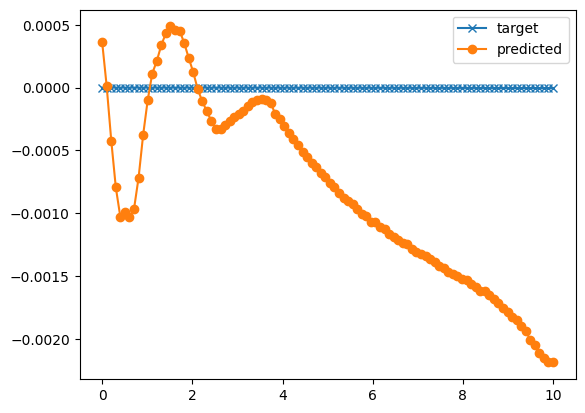

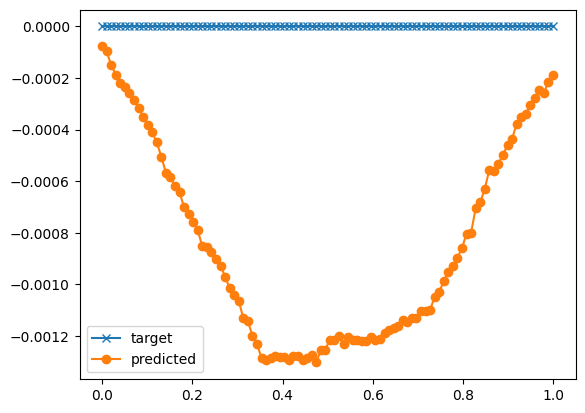

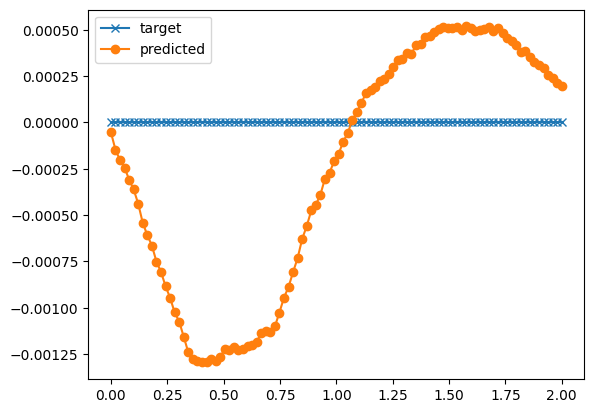

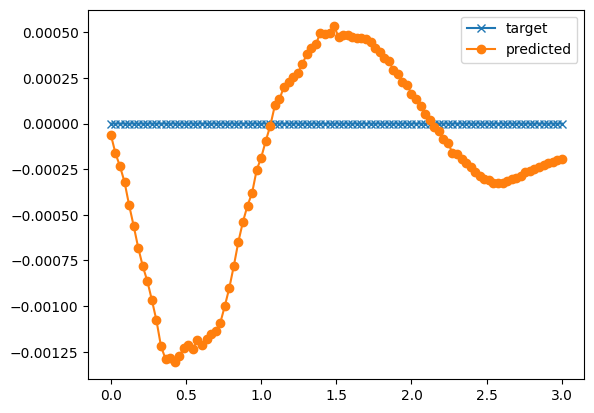

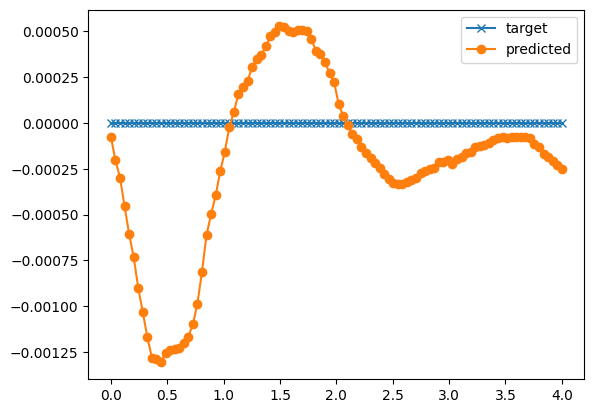

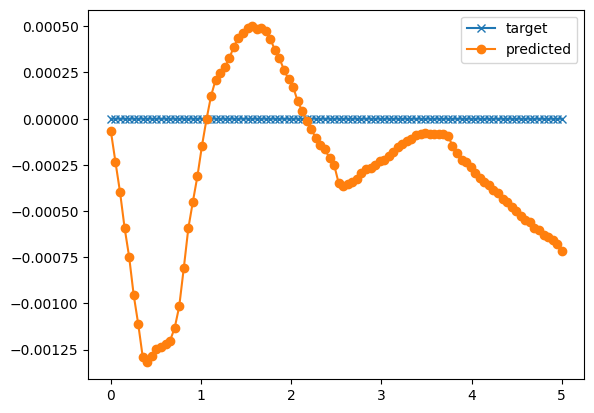

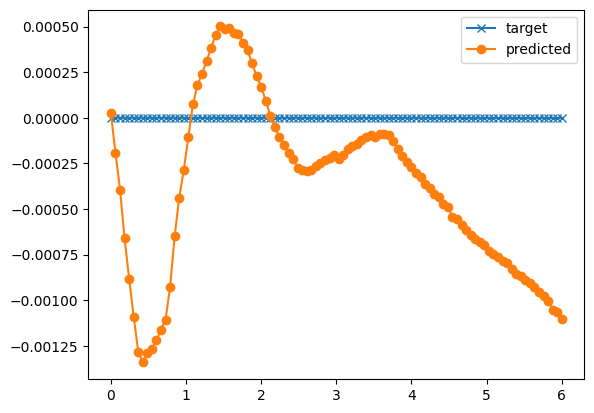

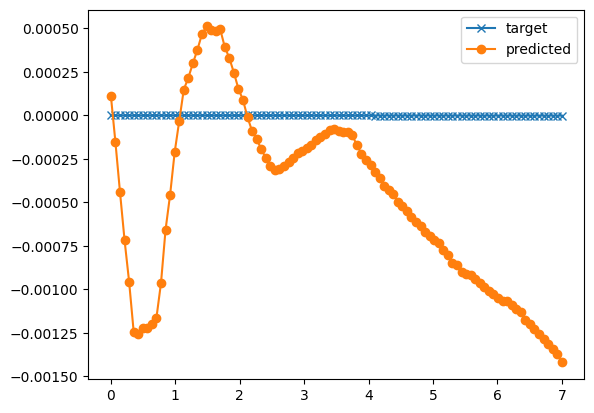

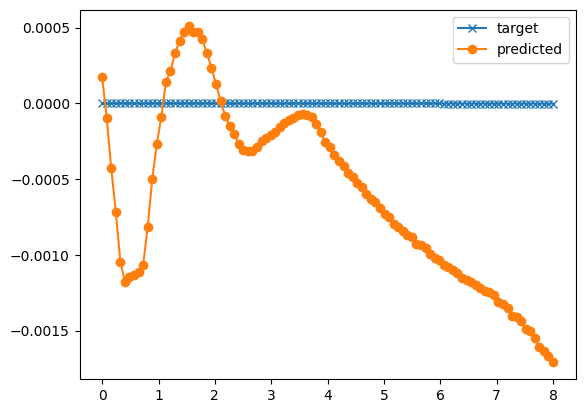

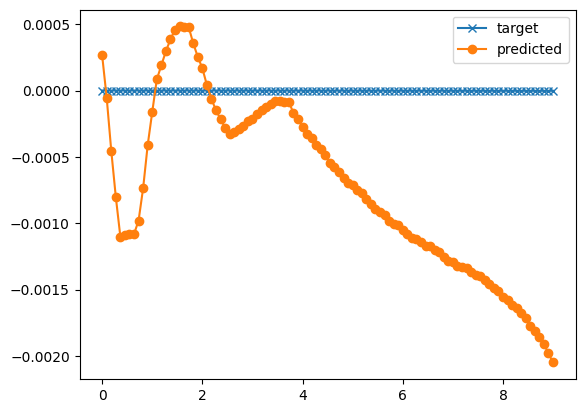

In [ ]:
# Test the model
def test_PDE(model, dataloader):
    loss = 0
    for batch_index, graph in enumerate(dataloader):
        model.eval()
        graph = graph.to(device)
        pred, target = model(graph)
        loss += F.mse_loss(pred, target).item()

    return loss / len(dataloader)

test_PDE(model, test_dataloader)

# Plot the results
plot_results(model, test_dataloader)